# WeRateDogs Tweet Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gather</a></li>
<li><a href="#assess">Assess</a></li>
<li><a href="#clean">Clean</a></li>
<li><a href="#analyse">Analyse</a></li>
</ul>

<a id='intro'></a>
## Introduction
The Twitter account <a href="https://twitter.com/dog_rates?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor">WeRateDogs</a> has an international reputation and over six million followers. Its tweets consist of a picture of person's dog, an accompanying humorous comment, and a rating (always with a denominator of 10, but often containing numerators like 12, 13, or larger).

Graciously, @dog_rates has provided an archive of their tweets and we engage in a process of data gathering, wrangling and producing visualisations to derive insights about this famous Twitter account and the nature of their tweets.

<a id='gather'></a>
## Gather Data

In [2]:
# import libraries
import pandas as pd
from bs4 import BeautifulSoup as bsp
import requests, tweepy, os, json

In [3]:
# load weRateDogs Twitter archive into dataframe
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# download the image predictions file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(os.path.join(os.getcwd(), url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

# load breed predictions into dataframe
predictions = pd.read_csv(url.split('/')[-1], sep='\t')

In [85]:
# create API object for gathering Twitter data
consumer_key = 'placeholder'
consumer_secret = 'placeholder'
access_token = 'placeholder'
access_secret = 'placeholder'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [5]:
# query Twitter API and store JSON in text file
tweets = list(archive.tweet_id)
data = []

for tweet in tweets:
    try:
        info = api.get_status(tweet)
        data.append(info._json)
    except:
        print('Nothing found for ID: {}'.format(tweet))

with open(os.path.join(os.getcwd(), 'tweet_json.txt'), mode = 'w') as file:
    json.dump(data, file)

Nothing found for ID: 888202515573088257
Nothing found for ID: 873697596434513921
Nothing found for ID: 869988702071779329
Nothing found for ID: 861769973181624320
Nothing found for ID: 842892208864923648
Nothing found for ID: 802247111496568832
Nothing found for ID: 775096608509886464
Nothing found for ID: 771004394259247104
Nothing found for ID: 758740312047005698
Nothing found for ID: 676957860086095872


In [5]:
# read text file into dataframe with Tweet ID, retweets and favourite count
data = []

with open(os.path.join(os.getcwd(), 'tweet_json.txt')) as file:
    tweets = json.load(file)
    for tweet in tweets:
        data.append({
            'tweet_id': tweet['id'],
            'retweets': tweet['retweet_count'],
            'favourites': tweet['favorite_count']
        })

interactions = pd.DataFrame(data, columns=['tweet_id', 'retweets', 'favourites'])

<a id="assess"></a>
## Assess Data

We have gathered our data from three different sources and loaded them into three different dataframes: `archive` contains the data from the Twitter archive file that was given to us, `predictions` contains the breed predictions from images run through the neural network, and `interactions` contains the per tweet favourite and retweet counts retrieved via the Twitter API. 

Now we are going to assess each dataframe visually and programmatically, defining the issues for cleaning. 

### archive

In [4]:
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


One first glance at the dataframe reveals issues, for example the value for `source` is HTML rather than a string. Some columns such as `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` seem to be almost always empty. This is not a quality issue, but rather a reflection of the fact that most of these tweets are not replies nor retweets. Let's investigate futher using Pandas functions.

In [6]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [8]:
archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [9]:
archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [10]:
sum(archive.tweet_id.duplicated())

0

In [11]:
archive.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Penny         10
Tucker        10
Lola          10
Bo             9
Winston        9
Sadie          8
the            8
an             7
Toby           7
Daisy          7
Bailey         7
Buddy          7
Oscar          6
Dave           6
Milo           6
Bella          6
Scout          6
Rusty          6
Koda           6
Jax            6
Leo            6
Jack           6
Stanley        6
Phil           5
            ... 
Dug            1
Laika          1
Maude          1
Mac            1
Florence       1
Sonny          1
Frönq          1
Pancake        1
Sundance       1
Luther         1
Lupe           1
Rudy           1
Jordy          1
Andru          1
Toffee         1
Naphaniel      1
Cal            1
Dex            1
Carter         1
Danny          1
Lulu           1
Grizzwald      1
Boots          1
Tino           1
Banjo          1
Duddles        1
Pawnd          1
Grady         

In [26]:
archive[archive.rating_denominator < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


In [35]:
archive.iloc[313].text

"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"

In [37]:
archive.in_reply_to_user_id.value_counts()

4.196984e+09    47
2.195506e+07     2
7.305050e+17     1
2.916630e+07     1
3.105441e+09     1
2.918590e+08     1
2.792810e+08     1
2.319108e+09     1
1.806710e+08     1
3.058208e+07     1
2.625958e+07     1
1.943518e+08     1
3.589728e+08     1
8.405479e+17     1
2.894131e+09     1
2.143566e+07     1
2.281182e+09     1
1.648776e+07     1
4.717297e+09     1
2.878549e+07     1
1.582854e+09     1
4.670367e+08     1
4.738443e+07     1
1.361572e+07     1
1.584641e+07     1
2.068372e+07     1
1.637468e+07     1
1.185634e+07     1
1.198989e+09     1
1.132119e+08     1
7.759620e+07     1
Name: in_reply_to_user_id, dtype: int64

### predictions

In [7]:
predictions.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


A preliminary visual inspection does not reveal any particular problems with this dataset. One issue would be the inconsistent formatting of values for the `p1`, `p2`, `p3` columns. Let's engage in programmatic assessment to investigate further.

In [14]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


No missing values, and correct datatypes: good. Let us see if there are any duplicate values

In [13]:
sum(predictions.tweet_id.duplicated())

0

### interactions

In [15]:
interactions.head(10)

,tweet_id,retweets,favourites
0,892420643555336193,8763,39227
1,892177421306343426,6422,33600
2,891815181378084864,4266,25313
3,891689557279858688,8849,42607
4,891327558926688256,9637,40771
5,891087950875897856,3209,20441
6,890971913173991426,2128,11987
7,890729181411237888,19368,66304
8,890609185150312448,4364,28061
9,890240255349198849,7603,32293


In [16]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2346 entries, 0 to 2345
Data columns (total 3 columns):
tweet_id      2346 non-null int64
retweets      2346 non-null int64
favourites    2346 non-null int64
dtypes: int64(3)
memory usage: 55.1 KB


In [17]:
sum(interactions.duplicated())

0

In [18]:
interactions.retweets.min()

0

In [19]:
interactions.favourites.max()

131514

### Issues

**Quality**

For the `archive` dataframe:

- `timestamp` not a datetime datatype
-  rows with `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` are unwanted retweets 
- `in_reply_to_status_id` is a float datatype
- `in_reply_to_user_id` is a float datatype
- `source` column values are in HTML

For the `predictions` dataframe:
- `p1, p2, p3` have strings that are poorly formatted

For the `interactions` dataframe:
- `retweets` are floats
- `favourites` are floats


**Tidiness**
- a tweet of a dog is a single observational unit, so all three dataframes should be merged together, with basic information about the tweet, the predicted breed, and favourites/retweet counts
- in the `archive` and `interactions` dataframe, `tweet_id` is not in numerical order

<a id='clean'></a>
## Clean Data

**1. Define:** we begin our cleaning process with tidiness, or structural issues. Let's merge all our dataframes together into one, because they relate to the same observational unit, a tweet from weRateDogs about a dog. The merging of dataframes will produce a **copy** that we can use for the rest of the cleaning process- killing two birds with one stone. First we right merge with the predictions dataframe, as we only want tweets with images, then we left merge with the interactions dataframe as not all tweets will be favourited or retweeted, so we keep them.

In [8]:
# code
m_one = pd.merge(archive, predictions, on=['tweet_id'], how='right')
master = pd.merge(m_one, interactions, on=['tweet_id'], how='left')

In [9]:
# test 
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 30 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2075 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          2075 non-null object
doggo                         2075 non-null object
floofer                       2075 non-null object
pupper                        2075 non-null object
puppo                         2075 non-null object
jpg_url                       2075 

In [10]:
# let's also take a sample from the merged dataframe
# to see that the text and image is consistent
master.iloc[300]

tweet_id                                                     828046555563323392
in_reply_to_status_id                                                       NaN
in_reply_to_user_id                                                         NaN
timestamp                                             2017-02-05 01:04:17 +0000
source                        <a href="http://twitter.com/download/iphone" r...
text                          This is Sailer. He waits on the roof for his o...
retweeted_status_id                                                         NaN
retweeted_status_user_id                                                    NaN
retweeted_status_timestamp                                                  NaN
expanded_urls                 https://twitter.com/dog_rates/status/828046555...
rating_numerator                                                             13
rating_denominator                                                           10
name                                    

**2. Define:** have the rows in our merged dataframe ordered numerically according to tweet ID (with the largest first), which is a newest to oldest ordering

In [11]:
# code
master.sort_values(['tweet_id'], ascending=False, inplace=True)

In [12]:
# test
master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,favourites
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8763.0,39227.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6422.0,33600.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4266.0,25313.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8849.0,42607.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9637.0,40771.0


**3. Define:** Convert `timestamp` to datetime datatype

In [13]:
# code
master.timestamp = pd.to_datetime(master['timestamp'])

In [14]:
# test
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 30 columns):
tweet_id                      2075 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null datetime64[ns]
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2075 non-null object
rating_numerator              2075 non-null int64
rating_denominator            2075 non-null int64
name                          2075 non-null object
doggo                         2075 non-null object
floofer                       2075 non-null object
pupper                        2075 non-null object
puppo                         2075 non-null object
jpg_url                    

**4. Define:** Convert `in_reply_to_status_id` to int datatype

In [15]:
# code
master.in_reply_to_status_id = master.in_reply_to_status_id.fillna(0.0).astype(int)

In [16]:
# test
master.in_reply_to_status_id.value_counts()

0                     2052
667152164079423488       2
674999807681908736       1
692041934689402880       1
684481074559381504       1
667806454573760512       1
733109485275860992       1
691416866452082688       1
670668383499735040       1
675349384339542016       1
674752233200820224       1
671561002136281088       1
759099523532779520       1
703041949650034688       1
671729906628341760       1
703255935813287936       1
675707330206547968       1
746885919387574272       1
674793399141146624       1
675497103322386432       1
684222868335505408       1
855818117272018944       1
729113531270991872       1
Name: in_reply_to_status_id, dtype: int64

**5. Define:** Convert `in_reply_to_user_id` to int datatype

In [17]:
# code
master.in_reply_to_user_id = master.in_reply_to_user_id.fillna(0.0).astype(int)

In [18]:
# test
master.in_reply_to_user_id.value_counts()

0             2052
4196983835      23
Name: in_reply_to_user_id, dtype: int64

**6. Define:** Drop any rows that are retweets, and then delete columns related to the tweet being a retweet

In [19]:
# code
retweets = master[master.retweeted_status_id > 0]
master.drop(retweets.index, inplace=True)

In [20]:
# test
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 30 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         1994 non-null int64
in_reply_to_user_id           1994 non-null int64
timestamp                     1994 non-null datetime64[ns]
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
jpg_url                       

In [21]:
# code
master.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

In [23]:
# test
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 27 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                

**7. Define:** convert retweets [count] to int

In [24]:
# code
master.retweets = master.retweets.fillna(0.0).astype(int)

In [25]:
# test
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 27 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                

**8. Define:** Convert favourites [count] to int 

In [26]:
# code
master.favourites = master.favourites.fillna(0.0).astype(int)

In [27]:
# test
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2074
Data columns (total 27 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
expanded_urls            1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
doggo                    1994 non-null object
floofer                  1994 non-null object
pupper                   1994 non-null object
puppo                    1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                

**9. Define:** Reformat the breed predictions in the `p1, p2, p3` columns for capitalisation and separated by spaces rather than underscores

In [28]:
# code
def format(breed):
    breed = breed.replace('_', ' ')
    return breed.title()

master.p1 = master.p1.apply(format)
master.p2 = master.p2.apply(format)
master.p3 = master.p3.apply(format)

In [34]:
# test
master.p1.value_counts()

Golden Retriever             139
Labrador Retriever            95
Pembroke                      88
Chihuahua                     79
Pug                           54
Chow                          41
Samoyed                       40
Toy Poodle                    38
Pomeranian                    38
Malamute                      29
Cocker Spaniel                27
French Bulldog                26
Chesapeake Bay Retriever      23
Miniature Pinscher            22
Seat Belt                     21
German Shepherd               20
Siberian Husky                20
Staffordshire Bullterrier     19
Maltese Dog                   18
Teddy                         18
Eskimo Dog                    18
Shetland Sheepdog             18
Beagle                        17
Shih-Tzu                      17
Rottweiler                    17
Cardigan                      17
Kuvasz                        16
Lakeland Terrier              16
Italian Greyhound             16
Web Site                      15
          

**10. Define:** Replace the HTML values in the `source` column with the actual tag string

In [41]:
# code
def extract(html):
    soup = bsp(html, 'html.parser')
    return soup.find('a').contents[0]

master.source = master.source.apply(extract)

In [42]:
# test
master.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

Now that we have assessed and cleaned our dataframe, let us save a copy and then use it to gain insight into the activity of the weRateDogs account and the nature of their tweets.

<a id="analyse"></a>
## Analyse Data

In [44]:
# let's save our cleaned data to a CSV file
master.to_csv('twitter_archive_master.csv', index=False)

### First Insight

How is weRateDogs posting all these Tweets? What hardware and software are they using?

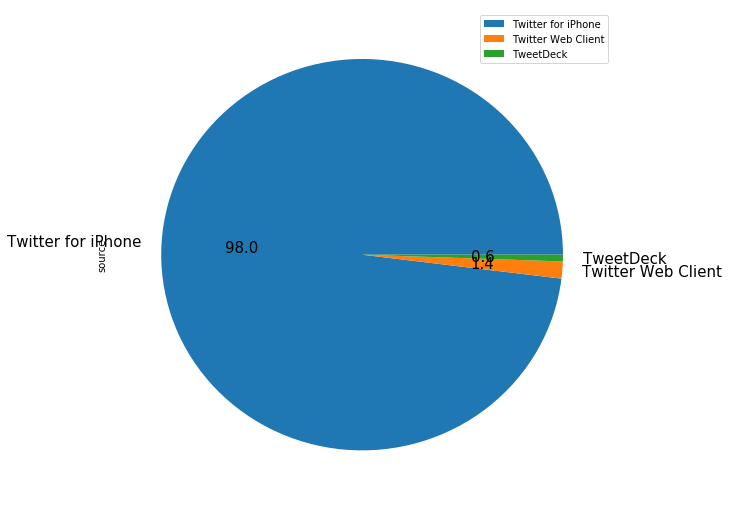

In [89]:
%matplotlib inline

master.source.value_counts().plot(kind='pie', autopct='%.1f', 
                                  figsize = [9,9], fontsize=15, legend=True)

So the vast majority of weRateDogs' tweets were made from an iPhone's Twitter app, with a tiny minority of tweets being made from other sources.

### Second Insight
Some of weRateDogs' tweets were made in reply to one other user. What proportion of the tweets were made to this user? What is the identity of the user?

In [84]:
master.in_reply_to_user_id.value_counts()

0             1971
4196983835      23
Name: in_reply_to_user_id, dtype: int64

In [86]:
user = api.get_user(4196983835)
user.screen_name

'dog_rates'

It appears that weRateDogs made those tweets in reply to itself. The data suggest that weRateDogs almost never tweets in reply to other users.

### Third Insight

Out of all the dogs tweeted which breed was most popular?

In [88]:
master.p1.value_counts()

Golden Retriever             139
Labrador Retriever            95
Pembroke                      88
Chihuahua                     79
Pug                           54
Chow                          41
Samoyed                       40
Toy Poodle                    38
Pomeranian                    38
Malamute                      29
Cocker Spaniel                27
French Bulldog                26
Chesapeake Bay Retriever      23
Miniature Pinscher            22
Seat Belt                     21
German Shepherd               20
Siberian Husky                20
Staffordshire Bullterrier     19
Maltese Dog                   18
Teddy                         18
Eskimo Dog                    18
Shetland Sheepdog             18
Beagle                        17
Shih-Tzu                      17
Rottweiler                    17
Cardigan                      17
Kuvasz                        16
Lakeland Terrier              16
Italian Greyhound             16
Web Site                      15
          

The data show that out of 1994 dogs tweeted, Golden Retrievers were most likely to be tweeted with 139. Retrievers were popular in general with another 95 Labradors tweeted.